In [1]:
'''Figure 2a and 2b: 
Validating the per-locus method (ABC and LRT) for all periods using simulated data'''

%pylab inline
from validation_functions import *
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib import pyplot as plt
PLOTDIR = '/storage/BonnieH/selection_project/validation_per_locus/figures/fig2ab/'

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Function to plot validation figures
def plot_figure(fig_num, opt_allele_list, est_s_dic, errors, s_vals, use_het, use_common, use_bins, num_bins, eps_bins, model, graph_type):
    
    plt.figure(fig_num)
    for opt_allele in opt_allele_list:
        per = 2
        if opt_allele == 6 or opt_allele == 12:
            per = 3
        if opt_allele == 7 or opt_allele == 10:
            per = 4
        if len(opt_allele_list) == 1:
            plt.errorbar(s_vals, est_s_dic[opt_allele], marker = 'o', label = str(opt_allele), yerr = errors[opt_allele])
            
        else:
            plt.errorbar(s_vals, est_s_dic[opt_allele], marker = 'o', label = 'Period: %d Opt allele: %d'%(per, opt_allele))
    
    if graph_type == 'abc':
        plt.plot( [10**-6,0.2],[10**-6,0.2] )
        plt.ylabel("Posterior estimation of s", size=15) 
        titlename = 'ABC Validation' 
        filename = PLOTDIR + 'ABC' 
        plt.yscale('log')
        
    if graph_type == 'lrt':
        plt.ylabel("Power", size=15) 
        titlename = 'LRT Validation'
        filename = PLOTDIR + 'LRT' 
    
    plt.xlabel("S value used for simulation", size=15)
    plt.xscale('log')
    plt.xlim(10**-6.5,0.3)
    plt.legend()
   
    opt_allele_string = '_'
    for opt_allele in opt_allele_list:
        opt_allele_string = opt_allele_string + str(opt_allele)
    filename = filename + opt_allele_string
    titlename = titlename + '\nSummary statistics used: '
    if use_het == 'y':
        filename = filename + '_het'
        titlename = titlename + 'Heterozygosity '
    if use_common == 'y':
        filename = filename + '_common'
        titlename = titlename + 'Number_Common_Alleles '
    if use_bins == 'y':
        filename = filename + '_' + str(num_bins) + 'bins' + '_' + str(eps_bins) 
        titlename = titlename + str(num_bins) + '_Allele_Bins '
    
    filename = filename + '_' + model + '.pdf' 
    titlename = titlename +  '\n'+ model 
    plt.title(titlename, size=15)
    plt.savefig(filename, bbox_inches='tight')
    print('Done figure ' + str(fig_num))

In [3]:
# Function to validate ABC and LRT
def validate(s_vals, use_het, use_common, use_bins, num_bins, abc_model, lrt_model, fig_num):
    
    per = 2
    opt_allele = '20,12,10' #'11,20,6,12,7,10'
    opt_allele_list, s_vals_dic, errors_s_dic, s_vals, p_vals_dic, errors_p_dic, eps_bins, LogLR_vals_dic = validate_per_locus(per, \
    opt_allele, s_vals, use_het, use_common, use_bins, num_bins, abc_model, lrt_model, True)
          
    # Plot ABC and LRT validation graphs
    fig_num = fig_num + 1
    plot_figure(fig_num, opt_allele_list, s_vals_dic, errors_s_dic, s_vals, use_het, use_common, use_bins, num_bins, eps_bins, abc_model, 'abc')
    fig_num = fig_num + 1
    plot_figure(fig_num, opt_allele_list, p_vals_dic, errors_p_dic, s_vals, use_het, use_common, use_bins, num_bins, eps_bins, lrt_model, 'lrt')
    return fig_num

In [4]:
def main():
    print('Running main')
    
    #s_vals = '0.000001,0.00001,0.0001,0.0004,0.0007,0.001,0.004,0.007,0.01,0.04,0.07,0.1,0.15,0.2' # S values to validate
    s_vals = '0.0001,0.001,0.01'
    
    # Summary statistics to use
    use_het = 'y'
    use_common = 'n'
    use_bin = 'y'
    
    #num_bins_list = [3,5,7] # Number of bins to use for validation
    num_bins = 5
    
    model = ('eurodem_p2','eurodem_merge')
    fig_num = 0
    
    # Run validation
    fig_num = validate(s_vals, use_het, use_common, use_bin, num_bins, model[0], model[1], fig_num)

Running main
Running per: 2 optimal allele: 20
Running per: 3 optimal allele: 12
Running per: 4 optimal allele: 10
Done figure 1
Done figure 2
CPU times: user 55.6 s, sys: 547 ms, total: 56.1 s
Wall time: 7min 59s


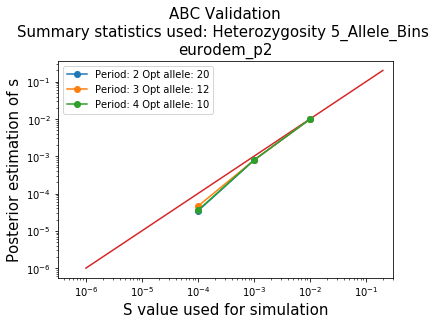

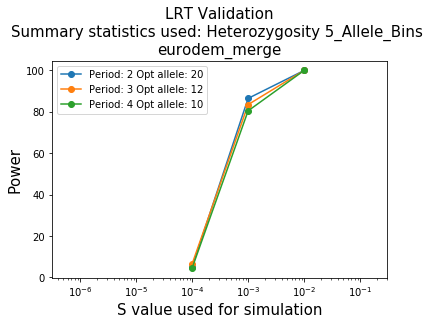

In [5]:
%%time
if __name__ == '__main__':
    main()